# Returns Prediction Model

Aim:  
1. Build model to predict returns in the next timestamp, based on previous analysis.
2. Market make in the current timestamp around that return prediction value. (Width of market can have something to do with accuracy of value)
3. Come up with some edge scheme for position and market width.

In this notebook we'll focus on building an LR model for returns first, trying to make that as accurate as possible. Edge scheme and market making strat can come later.

Feature Brainstorming: Want to brainstorm some features for returns model.  
- Previous (lagged) returns
- Volume
- Volatility Features (rolling sd)

Helpful plots to consider:  
- Scatter plots of features vs target, and features vs features
- Histograms of features and target to see whether they follow normal distribution. Generally LR more accurate and valid to run if they follow normal dist.

In [3]:
import pandas as pd
import numpy as np
kelp_df = pd.read_excel(r"squink.xlsx")
#Need to replace this with path to wherever the kelp data is

In [4]:
kelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   day              1000 non-null   int64  
 1   timestamp        1000 non-null   int64  
 2   product          1000 non-null   object 
 3   bid_price_1      1000 non-null   int64  
 4   bid_volume_1     1000 non-null   int64  
 5   bid_price_2      192 non-null    float64
 6   bid_volume_2     192 non-null    float64
 7   bid_price_3      25 non-null     float64
 8   bid_volume_3     25 non-null     float64
 9   ask_price_1      1000 non-null   int64  
 10  ask_volume_1     1000 non-null   int64  
 11  ask_price_2      217 non-null    float64
 12  ask_volume_2     217 non-null    float64
 13  ask_price_3      25 non-null     float64
 14  ask_volume_3     25 non-null     float64
 15  mid_price        1000 non-null   float64
 16  profit_and_loss  1000 non-null   int64  
dtypes: float64(9), 

We'll impute all the volume NaNs with 0, as that makes the most sense cos there is no volume there.

In [5]:
kelp_df[["bid_volume_1","bid_volume_2","bid_volume_3", "ask_volume_1", "ask_volume_2", "ask_volume_3"]] = kelp_df[["bid_volume_1","bid_volume_2","bid_volume_3", "ask_volume_1", "ask_volume_2", "ask_volume_3"]].fillna(0)

In [6]:
train_df = kelp_df.copy().iloc[:int(len(kelp_df) * 0.75)]
test_df = kelp_df.copy().drop(train_df.index, axis = 0)

In [7]:
train_df.loc[:,'log_return'] = np.log(train_df['mid_price'] / train_df['mid_price'].shift(1))

In [8]:
train_df.loc[:,'lag_1_return'] = train_df['log_return'].shift(1)

In [9]:
train_df

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,log_return,lag_1_return
0,1,0,SQUID_INK,1834,23,NaN,0.0,NaN,0.0,1838,23,NaN,0.0,NaN,0.0,1836.0,0,NaN,NaN
1,1,100,SQUID_INK,1837,1,1836.0,2.0,1835.0,22.0,1839,22,NaN,0.0,NaN,0.0,1838.0,0,0.001089,NaN
2,1,200,SQUID_INK,1832,22,NaN,0.0,NaN,0.0,1835,22,NaN,0.0,NaN,0.0,1833.5,0,-0.002451,0.001089
3,1,300,SQUID_INK,1836,1,1834.0,26.0,NaN,0.0,1837,26,NaN,0.0,NaN,0.0,1836.5,0,0.001635,-0.002451
4,1,400,SQUID_INK,1833,28,NaN,0.0,NaN,0.0,1836,28,NaN,0.0,NaN,0.0,1834.5,0,-0.001090,0.001635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,1,74500,SQUID_INK,1832,1,1831.0,3.0,1830.0,26.0,1833,26,NaN,0.0,NaN,0.0,1832.5,0,0.001092,-0.001092
746,1,74600,SQUID_INK,1830,30,NaN,0.0,NaN,0.0,1833,29,NaN,0.0,NaN,0.0,1831.5,0,-0.000546,0.001092
747,1,74700,SQUID_INK,1831,27,NaN,0.0,NaN,0.0,1834,27,NaN,0.0,NaN,0.0,1832.5,0,0.000546,-0.000546
748,1,74800,SQUID_INK,1831,27,NaN,0.0,NaN,0.0,1834,26,NaN,0.0,NaN,0.0,1832.5,0,0.000000,0.000546


For the volume feature, we are trying to see if the current ask_volume_1 or bid_volume_1 will affect the log return. Note that we need to lag the volume feature as we are using the current volume to predict future log_returns.

In [10]:
train_df["lag_1_bid_volume_1"] = train_df["bid_volume_1"].shift(1)
train_df["lag_1_ask_volume_1"] = train_df["ask_volume_1"].shift(1)

Lets create a feature for the difference between bids and asks. Hypothetically, if there is a large volume on the bid, we expect the price to go up in the future if we interpret this as heavy buying pressure.

In [11]:
train_df.loc[:,"lag_1_volume_difference"] = train_df["lag_1_bid_volume_1"] - train_df["lag_1_ask_volume_1"]

Lets create a ratio volume feature to also capture dividing relationships.

In [12]:
train_df.loc[:,"lag_1_volume_ratio"] = train_df["lag_1_bid_volume_1"] / train_df["lag_1_ask_volume_1"]

Lets plot these out against log returns to see what the trend looks like.

In [13]:
train_df.loc[:, "lag_1_bid_volume_2"] = train_df["bid_volume_2"].shift(1)
train_df.loc[:, "lag_1_ask_volume_2"] = train_df["ask_volume_2"].shift(1)
train_df.loc[:, "lag_1_bid_volume_3"] = train_df["bid_volume_3"].shift(1)
train_df.loc[:, "lag_1_ask_volume_3"] = train_df["ask_volume_3"].shift(1)

In [14]:
train_df["lag_1_total_bid_volume"] = train_df["lag_1_bid_volume_1"] + train_df["lag_1_bid_volume_2"] + train_df["lag_1_bid_volume_3"]
train_df["lag_1_total_ask_volume"] = train_df["lag_1_ask_volume_1"] + train_df["lag_1_ask_volume_2"] + train_df["lag_1_ask_volume_3"]

In [15]:
train_df.loc[:,"lag_2_volume_difference"] = train_df["lag_1_bid_volume_2"] - train_df["lag_1_ask_volume_2"]
train_df.loc[:,"lag_3_volume_difference"] = train_df["lag_1_bid_volume_3"] - train_df["lag_1_ask_volume_3"]

One idea is that the third level volume isn't that important as the first volume so perhaps we could multiply it by a constant instead of doing a sum. Maybe a PCA?

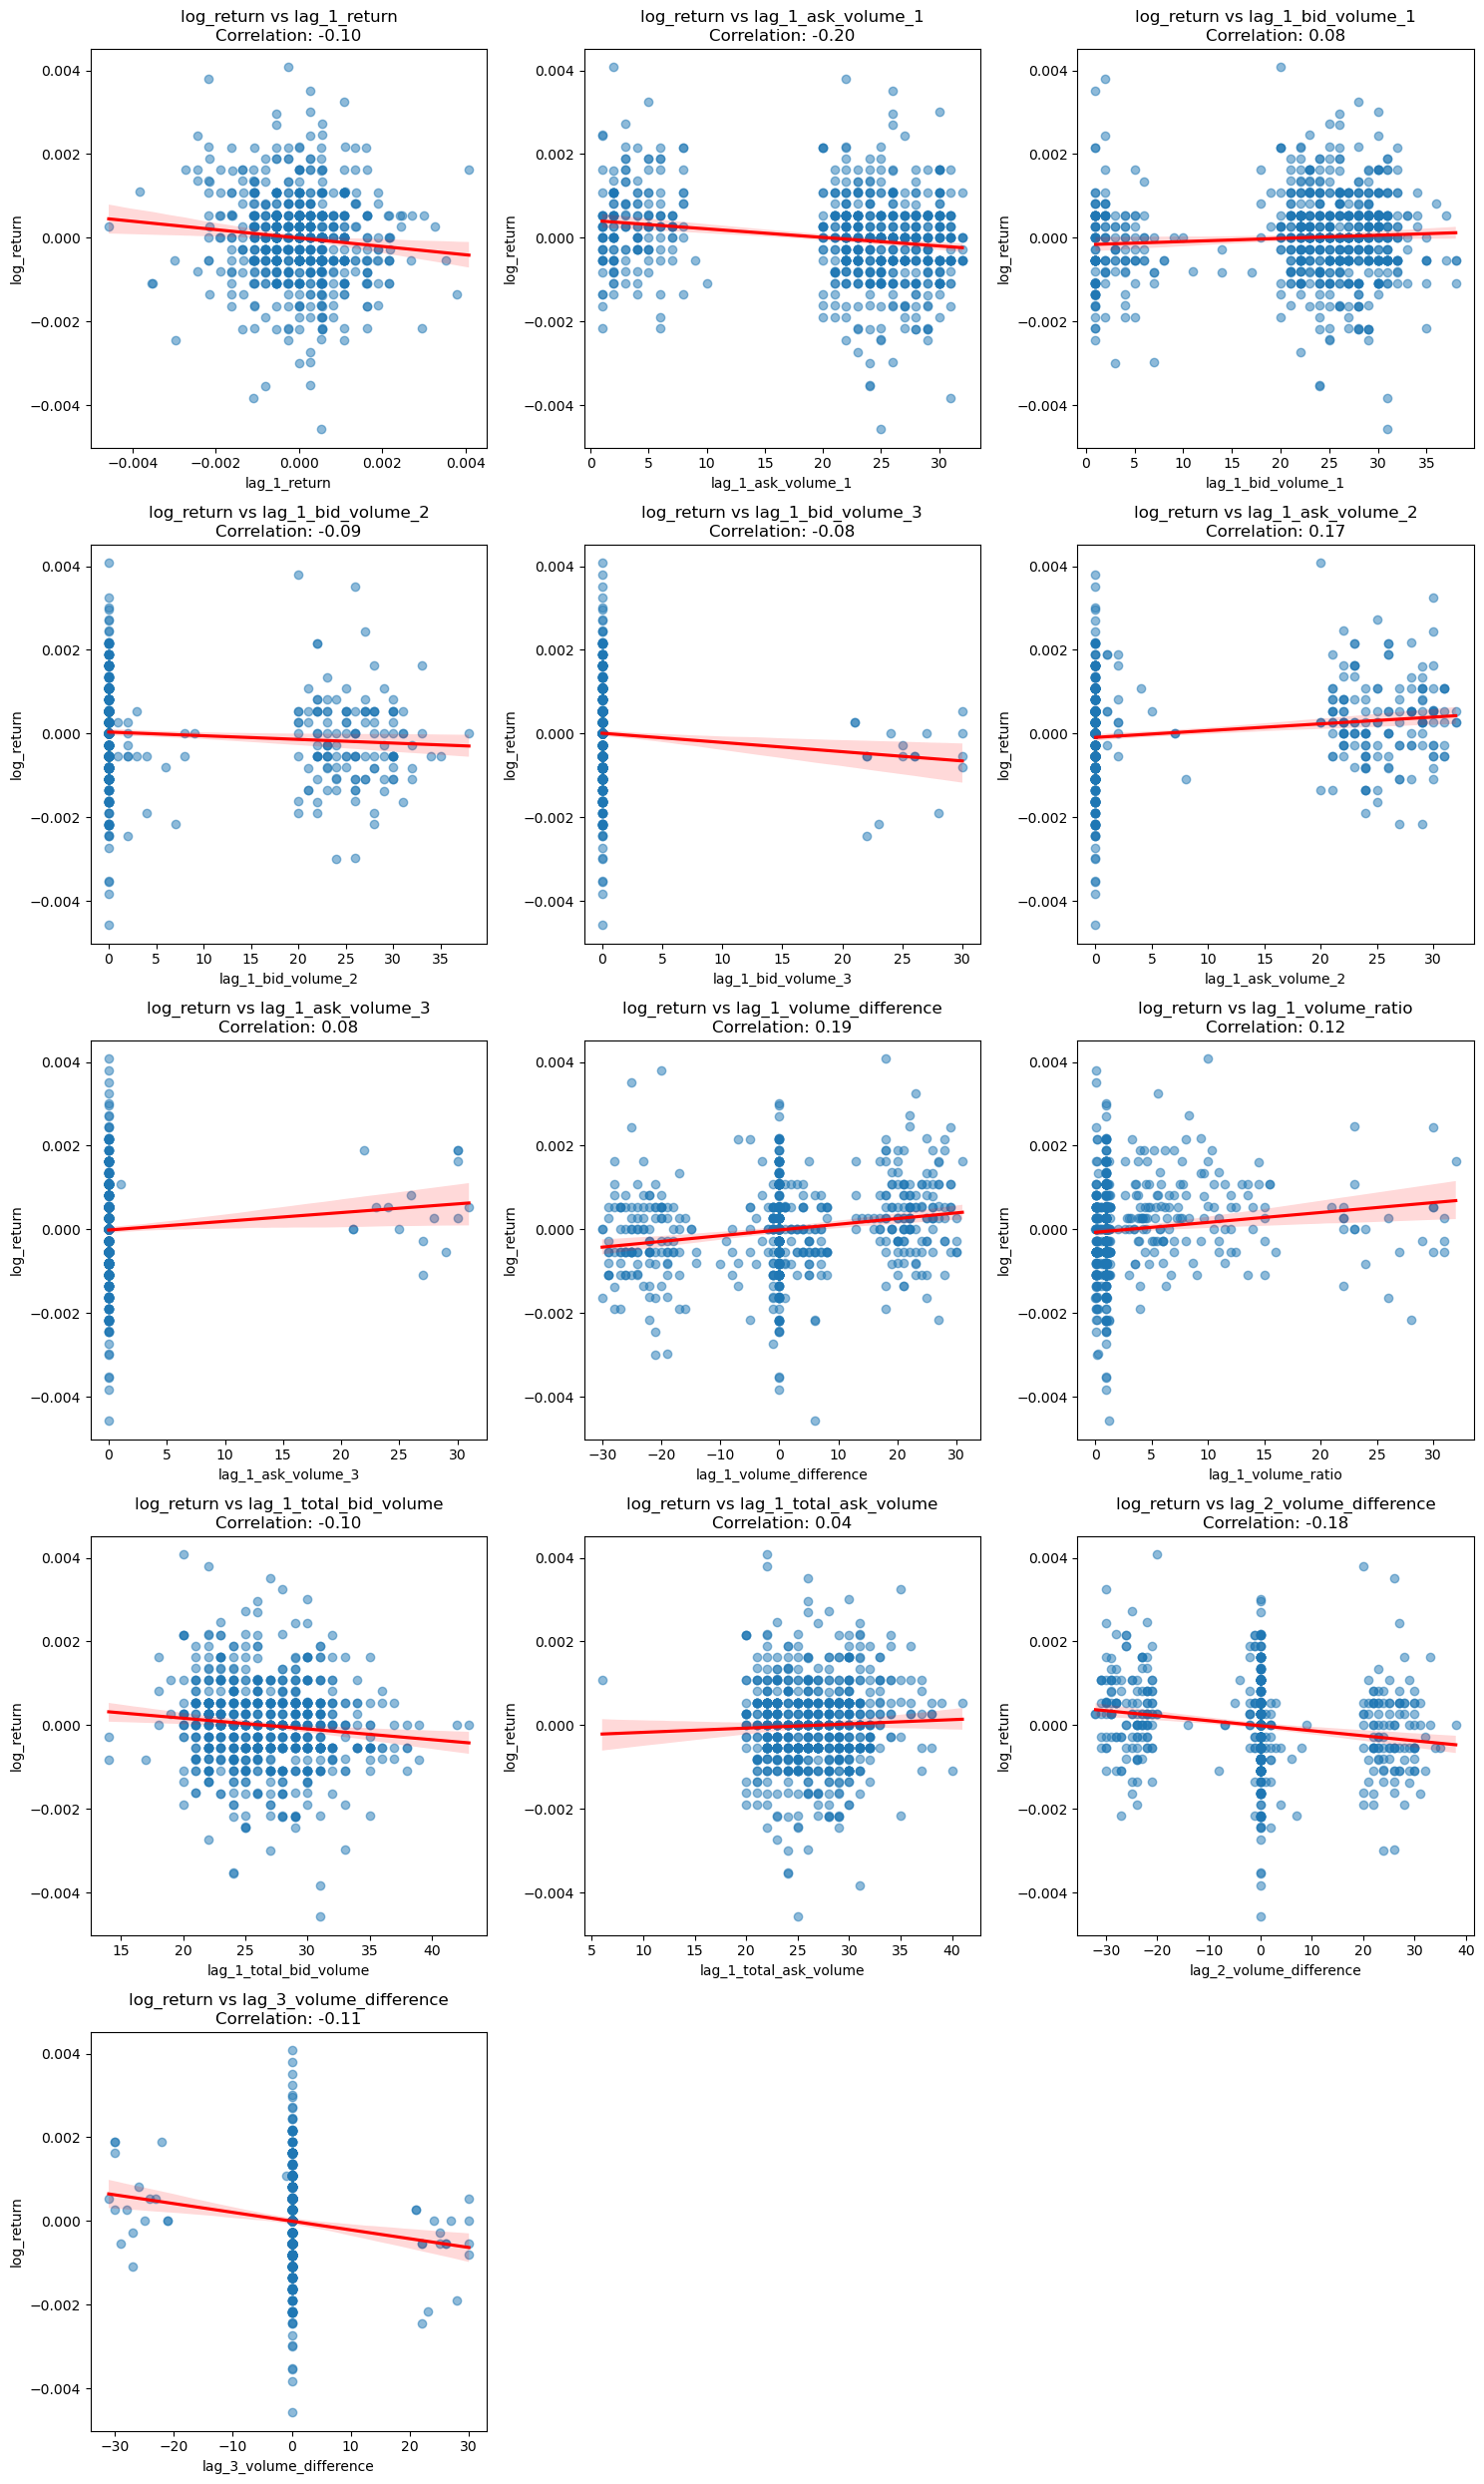

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define target and features
target = 'log_return'
features = [
    'lag_1_return', 'lag_1_ask_volume_1', 'lag_1_bid_volume_1', "lag_1_bid_volume_2", "lag_1_bid_volume_3",
    "lag_1_ask_volume_2", "lag_1_ask_volume_3", 'lag_1_volume_difference', 'lag_1_volume_ratio',
    "lag_1_total_bid_volume", "lag_1_total_ask_volume", "lag_2_volume_difference", "lag_3_volume_difference"
]

# Define the number of columns and calculate rows dynamically
ncols = 3
nrows = int(np.ceil(len(features) / ncols))  # Ensure enough rows for all features

# Set up subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Flatten for easy iteration

# Iterate through features and plot
for i, feature in enumerate(features):
    temp_df = train_df[[target, feature]].dropna()  # Temporarily drop NaNs

    sns.regplot(x=temp_df[feature], y=temp_df[target], ax=axes[i], scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    correlation = temp_df[feature].corr(temp_df[target])
    axes[i].set_title(f'{target} vs {feature}\nCorrelation: {correlation:.2f}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target)

# Hide any unused subplots (in case len(features) % 3 != 0)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


It seems like beyond the top layer the volume orders don't provide much more information correlation-wise with the target. Second level volume seems somewhat useful. However, there's not much data beyond top layer so we'll just stick with top layer for now. It seems like the difference for the 2nd and 3rd layer is not that helpful as we so rarely have a full row of lag 2 / 3 data.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

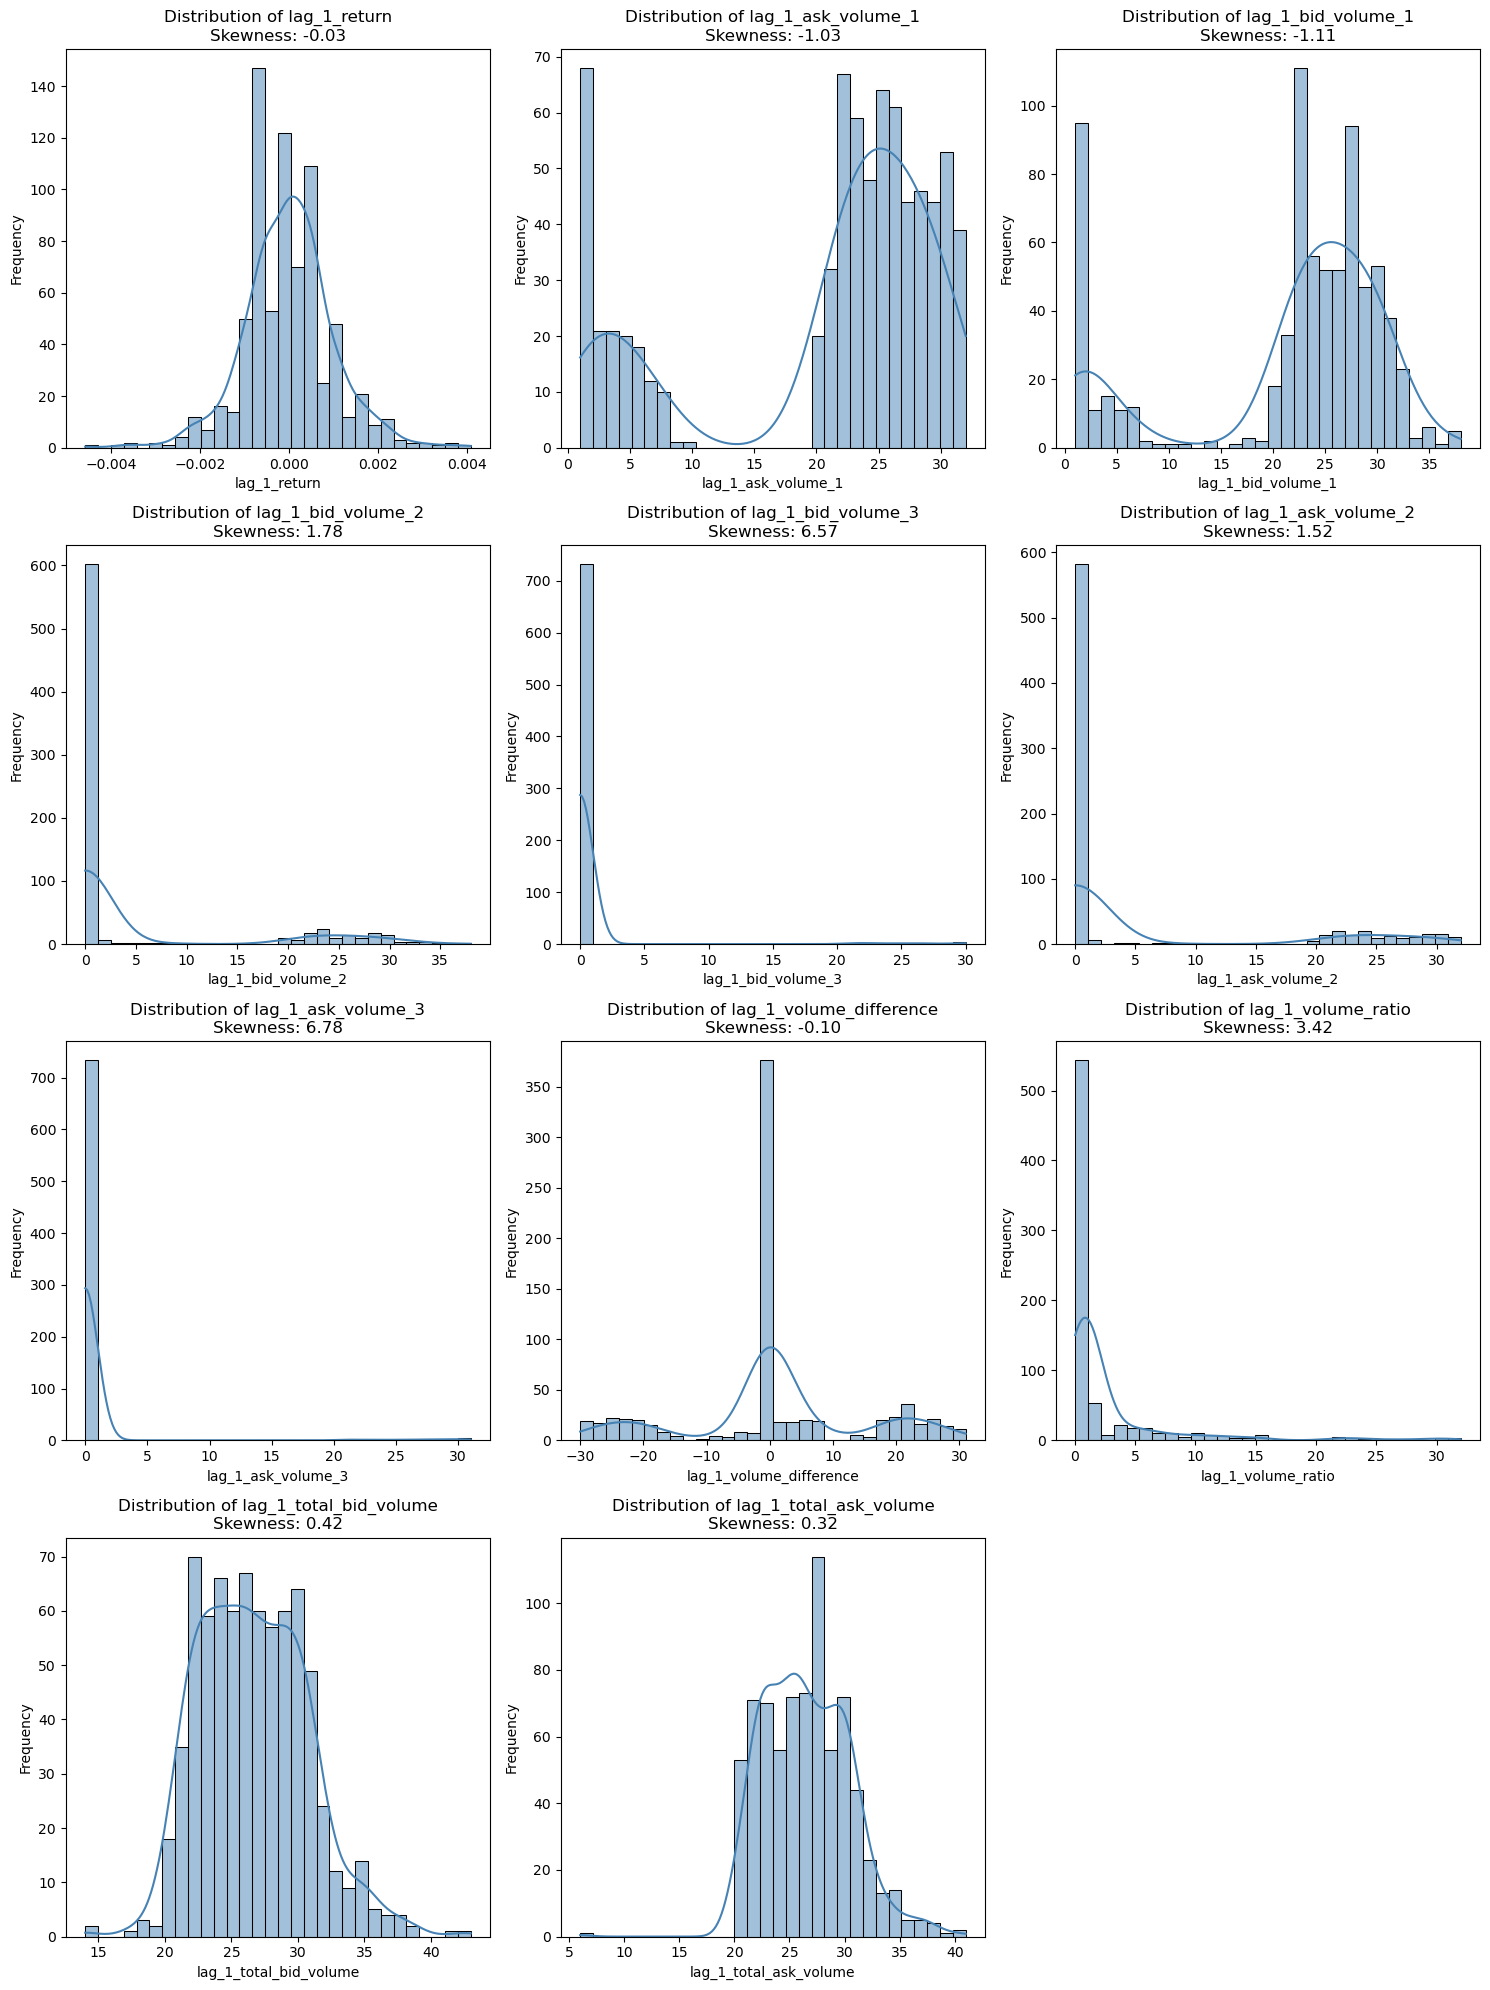

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew

# Define features
features = [
    'lag_1_return', 'lag_1_ask_volume_1', 'lag_1_bid_volume_1', "lag_1_bid_volume_2", "lag_1_bid_volume_3",
    "lag_1_ask_volume_2", "lag_1_ask_volume_3", 'lag_1_volume_difference', 'lag_1_volume_ratio',
    "lag_1_total_bid_volume", "lag_1_total_ask_volume"
]

# Define number of columns and calculate rows dynamically
ncols = 3
nrows = int(np.ceil(len(features) / ncols))

# Set up subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Flatten for easy iteration

# Iterate through features and plot histograms with KDEs
for i, feature in enumerate(features):
    temp_df = train_df[feature].dropna()  # Drop NaNs before calculations

    # Compute skewness
    feature_skewness = skew(temp_df) if not temp_df.empty else np.nan  

    # Plot histogram with KDE
    sns.histplot(temp_df, kde=True, ax=axes[i], bins=30, color='steelblue')

    # Set title with skewness
    axes[i].set_title(f'Distribution of {feature}\nSkewness: {feature_skewness:.2f}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


From the plot, it seems like for the volume difference features (and most of the volume features) a random forest model will be the most helpful. This is because the volume data seems to be bi or trimodal with each group having a different mean log return, so a random forest will be able to capture these groups better.

Lets build a LR model to predict log_returns.

In [18]:
kelp_copy = kelp_df.copy()

In [19]:
kelp_copy.loc[:,'log_return'] = np.log(kelp_copy['mid_price'] / kelp_copy['mid_price'].shift(1))
kelp_copy.loc[:,'lag_1_return'] = kelp_copy['log_return'].shift(1)
kelp_copy["lag_1_bid_volume_1"] = kelp_copy["bid_volume_1"].shift(1)
kelp_copy["lag_1_ask_volume_1"] = kelp_copy["ask_volume_1"].shift(1)
kelp_copy.loc[:,"lag_1_volume_difference"] = kelp_copy["lag_1_bid_volume_1"] - kelp_copy["lag_1_ask_volume_1"]
kelp_copy.loc[:,"lag_1_volume_ratio"] = kelp_copy["lag_1_bid_volume_1"] / kelp_copy["lag_1_ask_volume_1"]
kelp_copy.loc[:, "lag_1_bid_volume_2"] = kelp_copy["bid_volume_2"].shift(1)
kelp_copy.loc[:, "lag_1_ask_volume_2"] = kelp_copy["ask_volume_2"].shift(1)
kelp_copy.loc[:, "lag_1_bid_volume_3"] = kelp_copy["bid_volume_3"].shift(1)
kelp_copy.loc[:, "lag_1_ask_volume_3"] = kelp_copy["ask_volume_3"].shift(1)
kelp_copy["lag_1_total_bid_volume"] = kelp_copy["lag_1_bid_volume_1"] + kelp_copy["lag_1_bid_volume_2"] + kelp_copy["lag_1_bid_volume_3"]
kelp_copy["lag_1_total_ask_volume"] = kelp_copy["lag_1_ask_volume_1"] + kelp_copy["lag_1_ask_volume_2"] + kelp_copy["lag_1_ask_volume_3"]
kelp_copy.loc[:,"lag_2_volume_difference"] = kelp_copy["lag_1_bid_volume_2"] - kelp_copy["lag_1_ask_volume_2"]
kelp_copy.loc[:,"lag_3_volume_difference"] = kelp_copy["lag_1_bid_volume_3"] - kelp_copy["lag_1_ask_volume_3"]
kelp_copy['lagged_log_return_of_bid_volume_1'] = np.log(kelp_copy['bid_volume_1']) - np.log(kelp_copy['bid_volume_1'].shift(1)).shift(1)
kelp_copy['lagged_log_return_of_ask_volume_1'] = np.log(kelp_copy['ask_volume_1']) - np.log(kelp_copy['ask_volume_1'].shift(1)).shift(1)

test_df = kelp_copy.copy().drop(train_df.index, axis = 0)

In [20]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import numpy as np

# Define features and target
features = ['lag_1_ask_volume_1', 'lag_1_ask_volume_2', 'lag_1_bid_volume_1', 
            'lag_1_bid_volume_2', "lag_1_ask_volume_3", "lag_1_bid_volume_3",'lag_1_return']
target = 'log_return'

# Drop NaNs in both train and test sets
train_data = train_df[features + [target]].dropna() 
test_data = test_df[features + [target]].dropna()

# Separate the features and target for training and testing
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

# Add constant term (intercept) to the features for statsmodels
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Initialize the Linear Regression model using statsmodels
model = sm.OLS(y_train, X_train)

# Fit the model
results = model.fit()

# Print the summary of the regression model
print(results.summary())

# Make predictions on the test data
y_pred = results.predict(X_test)

# Calculate the Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)

# Display the result
print(f'Mean Squared Error (MSE) on the Test Set: {mse:.10f}')


                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     6.309
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           3.28e-07
Time:                        19:44:44   Log-Likelihood:                 4124.5
No. Observations:                 748   AIC:                            -8233.
Df Residuals:                     740   BIC:                            -8196.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0005      0

Lets investigate the large condition number.

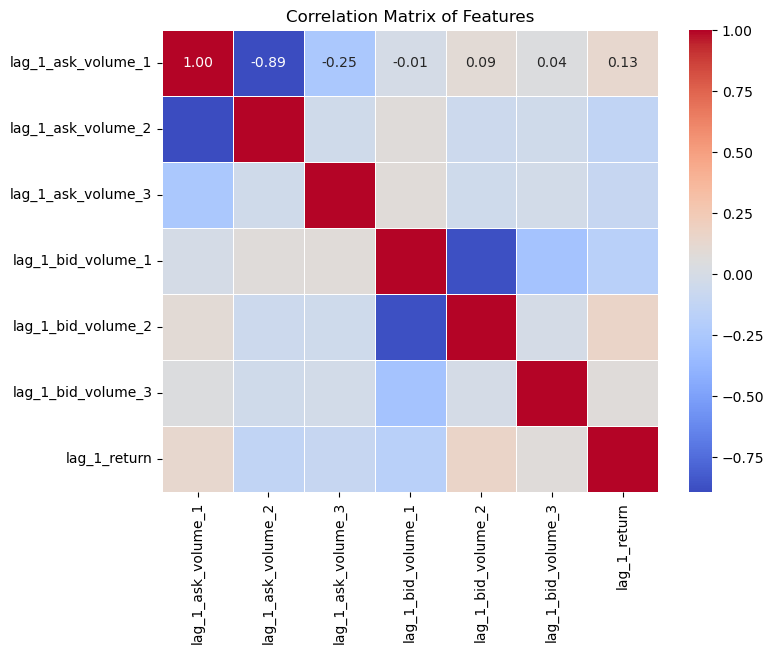

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the features
features = ['lag_1_ask_volume_1', 'lag_1_ask_volume_2', "lag_1_ask_volume_3", 'lag_1_bid_volume_1', 
            'lag_1_bid_volume_2', "lag_1_bid_volume_3", 'lag_1_return']

# Create a correlation matrix from train_df
corr_matrix = train_df[features].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()


It seems like the bids and asks don't have strong correlation with each other, but the bids have strong correlation with themselves, and the asks have strong correlations with themselves. Perhaps we could create a PCA feature. (We won't bother with normalisation now)

Decide to not standardise before PCAing as the volume features should all be roughly on the same scale. Naturally top level volume will be bigger absolute value (bigger sd) so we don't want to lose this information.

In [22]:
from sklearn.decomposition import PCA
import numpy as np

# Define the features for PCA (Ask volume features)
ask_volume_features = ['lag_1_ask_volume_1', 'lag_1_ask_volume_2', 'lag_1_ask_volume_3']

# Perform PCA on the training data (without standardization)
pca = PCA(n_components=1)  # We want the top 1 component
ask_volume_PCA = pca.fit_transform(train_df[ask_volume_features].dropna(subset=['lag_1_ask_volume_1', 'lag_1_ask_volume_2', 'lag_1_ask_volume_3'], axis=0))

# Create a new feature for the top PCA component in train_df
train_df['ask_volume_PCA'] = np.concatenate((np.array([[np.nan]]), ask_volume_PCA))

# Display the explained variance ratio for the top component
explained_variance_ratio = pca.explained_variance_ratio_
print(f'Explained Variance Ratio of Top PCA Component: {explained_variance_ratio[0]:.4f}')

# Apply the same PCA transformation to the test data (without standardization)
ask_volume_PCA_test = pca.transform(test_df[ask_volume_features].dropna(subset=['lag_1_ask_volume_1', 'lag_1_ask_volume_2', 'lag_1_ask_volume_3'], axis=0))

# Create a new feature for the top PCA component in test_df
test_df['ask_volume_PCA'] = ask_volume_PCA_test


Explained Variance Ratio of Top PCA Component: 0.8827


In [23]:
from sklearn.decomposition import PCA
import numpy as np

# Define the features for PCA (Bid volume features)
bid_volume_features = ['lag_1_bid_volume_1', 'lag_1_bid_volume_2', 'lag_1_bid_volume_3']

# Perform PCA on the training data (without standardization)
pca = PCA(n_components=1)  # We want the top 1 component
bid_volume_PCA = pca.fit_transform(train_df[bid_volume_features].dropna(subset=['lag_1_bid_volume_1', 'lag_1_bid_volume_2', 'lag_1_bid_volume_3'], axis=0))

# Create a new feature for the top PCA component in train_df
train_df['bid_volume_PCA'] = np.concatenate((np.array([[np.nan]]), bid_volume_PCA))

# Display the explained variance ratio for the top component
explained_variance_ratio = pca.explained_variance_ratio_
print(f'Explained Variance Ratio of Top PCA Component: {explained_variance_ratio[0]:.4f}')

# Apply the same PCA transformation to the test data (without standardization)
bid_volume_PCA_test = pca.transform(test_df[bid_volume_features].dropna(subset=['lag_1_bid_volume_1', 'lag_1_bid_volume_2', 'lag_1_bid_volume_3'], axis=0))

# Create a new feature for the top PCA component in test_df
test_df['bid_volume_PCA'] = bid_volume_PCA_test


Explained Variance Ratio of Top PCA Component: 0.8741


Lets compare the performance of a model with just the top-level volumes and lag_returns versus pca_features and lag_returns

In [24]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import numpy as np

# Define features and target
features = ['lag_1_ask_volume_1', 'lag_1_bid_volume_1','lag_1_return']
target = 'log_return'

# Drop NaNs in both train and test sets
train_data = train_df[features + [target]].dropna() 
test_data = test_df[features + [target]].dropna()

# Separate the features and target for training and testing
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

# Add constant term (intercept) to the features for statsmodels
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Initialize the Linear Regression model using statsmodels
model = sm.OLS(y_train, X_train)

# Fit the model
results = model.fit()

# Print the summary of the regression model
print(results.summary())

# Make predictions on the test data
y_pred = results.predict(X_test)

# Calculate the Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)

# Display the result
print(f'Mean Squared Error (MSE) on the Test Set: {mse:.10f}')


                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     12.59
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           4.90e-08
Time:                        19:44:45   Log-Likelihood:                 4121.3
No. Observations:                 748   AIC:                            -8235.
Df Residuals:                     744   BIC:                            -8216.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0003      0

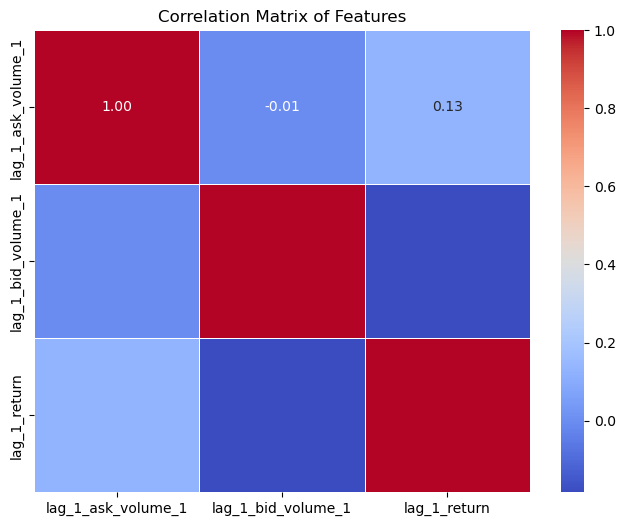

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the features
features = ['lag_1_ask_volume_1', 'lag_1_bid_volume_1','lag_1_return']

# Create a correlation matrix from train_df
corr_matrix = train_df[features].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()


It seems like another problem with combining LR for lag returns and volume is that the volume and lag_1_return are correlated so this presents some multicollinearity issues with our model.

In [26]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import numpy as np

# Define features and target
features = ['ask_volume_PCA', 'bid_volume_PCA','lag_1_return']
target = 'log_return'

# Drop NaNs in both train and test sets
train_data = train_df[features + [target]].dropna() 
test_data = test_df[features + [target]].dropna()

# Separate the features and target for training and testing
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

# Add constant term (intercept) to the features for statsmodels
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Initialize the Linear Regression model using statsmodels
model = sm.OLS(y_train, X_train)

# Fit the model
results = model.fit()

# Print the summary of the regression model
print(results.summary())

# Make predictions on the test data
y_pred = results.predict(X_test)

# Calculate the Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)

# Display the result
print(f'Mean Squared Error (MSE) on the Test Set: {mse:.10f}')


                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     11.57
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           2.02e-07
Time:                        19:44:45   Log-Likelihood:                 4119.9
No. Observations:                 748   AIC:                            -8232.
Df Residuals:                     744   BIC:                            -8213.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.242e-06    3.6e-05     -0.

PCAs do reduce multicollinearity issues and improve test MSE slightly from only a top level volume model. However it still displays the multicollinearity issue due to the PCAs and lag_1_return being correlated.

Lets try a hybrid LR RF model, where we use an LR from lag_1_returns to predict returns, and then the residuals we will fit a random forest model to using the volume features. As RF handles multicollinearity well and we have a small number of volume features compared to datapoints we likely won't need to use the PCA features much in RF model.

Below is the base LR model with the only the lag_1 autocorrelation feature.

In [27]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define features and target
features = ['lag_1_return']
target = 'log_return'

# Drop NaNs in both train and test sets
train_data = train_df[features + [target]].dropna()
test_data = test_df[features + [target]].dropna()

# Separate the features and target for training and testing
X_train = train_data[features].copy()  # Copy ensures original DataFrame is not modified
y_train = train_data[target]

X_test = test_data[features].copy()
y_test = test_data[target]

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame (optional, but useful for debugging)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Add constant term (intercept) after scaling
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Initialize the Linear Regression model using statsmodels
model = sm.OLS(y_train, X_train_scaled)

# Fit the model
results = model.fit()

# Print the summary of the regression model
print(results.summary())

# Make predictions on the test data
y_pred = results.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)

# Calculate R² on the test set
r2 = r2_score(y_test, y_pred)

# Display the results
print(f'Mean Squared Error (MSE) on the Test Set: {mse:.10f}')
print(f'R² Value on the Test Set: {r2:.6f}')


                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     7.564
Date:                Tue, 08 Apr 2025   Prob (F-statistic):            0.00610
Time:                        19:44:45   Log-Likelihood:                 4106.6
No. Observations:                 748   AIC:                            -8209.
Df Residuals:                     746   BIC:                            -8200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -4.007e-06   3.66e-05     -0.110   

In [28]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define features for each model
linear_features = ['lag_1_return']
rf_features = ['ask_volume_PCA', 'bid_volume_PCA', 'lag_1_return']
target = 'log_return'

# Drop NaNs in both train and test sets
train_data = train_df[['ask_volume_PCA', 'bid_volume_PCA', 'lag_1_return', 'log_return']].dropna() 
test_data = test_df[['ask_volume_PCA', 'bid_volume_PCA', 'lag_1_return', 'log_return']].dropna()

# Separate the features and target for training and testing
X_train_lin = train_data[linear_features]
y_train = train_data[target]

X_test_lin = test_data[linear_features]
y_test = test_data[target]

# Initialize scaler for scaling the features
scaler = StandardScaler()

# Scale the features (but don't affect original DataFrames)
X_train_lin_scaled = scaler.fit_transform(X_train_lin)
X_test_lin_scaled = scaler.transform(X_test_lin)

# Add constant term (intercept) to the scaled features for statsmodels
X_train_lin_scaled = sm.add_constant(X_train_lin_scaled)
X_test_lin_scaled = sm.add_constant(X_test_lin_scaled)

# Initialize and train the Linear Regression model
model = sm.OLS(y_train, X_train_lin_scaled)
results = model.fit()

# Print the summary of the regression model
print(results.summary())

# Predict log returns using the Linear Regression model
y_pred_lin_train = results.predict(X_train_lin_scaled)
y_pred_lin_test = results.predict(X_test_lin_scaled)

# Compute residuals (errors from the linear model)
residuals_train = y_train - y_pred_lin_train

# Train a Random Forest on the residuals using additional features
X_train_rf = train_data[rf_features]
X_test_rf = test_data[rf_features]

# Scale the features for Random Forest (we'll scale these separately)
X_train_rf_scaled = scaler.fit_transform(X_train_rf)
X_test_rf_scaled = scaler.transform(X_test_rf)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_rf_scaled, residuals_train)

# Predict residuals using the Random Forest model
residuals_test_pred = rf_model.predict(X_test_rf_scaled)

# Hybrid Model Prediction = Linear Model Prediction + Residual Correction
y_pred_hybrid = y_pred_lin_test + residuals_test_pred

# Calculate the Mean Squared Error (MSE) on the hybrid model
mse_hybrid = mean_squared_error(y_test, y_pred_hybrid)

# Calculate R^2 on the hybrid model
r2_hybrid = r2_score(y_test, y_pred_hybrid)

# Display the results
print(f'Mean Squared Error (MSE) on the Hybrid Model: {mse_hybrid:.10f}')
print(f'Test R² Value (Hybrid Model): {r2_hybrid:.6f}')


                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     7.564
Date:                Tue, 08 Apr 2025   Prob (F-statistic):            0.00610
Time:                        19:44:48   Log-Likelihood:                 4106.6
No. Observations:                 748   AIC:                            -8209.
Df Residuals:                     746   BIC:                            -8200.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.007e-06   3.66e-05     -0.110      0.9

We see that the RF increases R^2 only slightly. This makes sense given that most of the trends are linear so LR is best at modelling them.

Lets retry the LR model from before with volume and lag features with standardisation to see if collinearity is still a big issue. We will also try adding in an interaction term to try capture the volume-lag relationship effects.

In [29]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define features and target
features = ['ask_volume_PCA', 'bid_volume_PCA', 'lag_1_return']
target = 'log_return'

# Drop NaNs in both train and test sets
train_data = train_df[features + [target]].dropna() 
test_data = test_df[features + [target]].dropna()

# Separate the features and target for training and testing
X_train = train_data[features].copy()  # Copy ensures original DataFrame is not modified
y_train = train_data[target]

X_test = test_data[features].copy()
y_test = test_data[target]

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame (optional, but useful for debugging)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Add constant term (intercept) after scaling
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Initialize and fit the Linear Regression model using statsmodels
model = sm.OLS(y_train, X_train_scaled)
results = model.fit()

# Print the summary of the regression model
print(results.summary())

# Make predictions on the test data
y_pred = results.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)

# Calculate R² on the test set
r2 = r2_score(y_test, y_pred)

# Display the results
print(f'Mean Squared Error (MSE) on the Test Set: {mse:.10f}')
print(f'R² Value on the Test Set: {r2:.6f}')


                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     11.57
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           2.02e-07
Time:                        19:44:48   Log-Likelihood:                 4119.9
No. Observations:                 748   AIC:                            -8232.
Df Residuals:                     744   BIC:                            -8213.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -4.007e-06    3.6e-05     -0.

It seems like the condition number issues were greatly reduced after standardising the data. Now lets try adding in interaction terms, as it seems when the lagged return and the current volume are both high then the future log returns shouldn't be as high as we expect due to the correlation between the two.

In [30]:
train_df['lag_1_askvol_return_interaction'] = train_df['ask_volume_PCA'] * train_df['lag_1_return']
train_df['lag_1_bidvol_return_interaction'] = train_df['bid_volume_PCA'] * train_df['lag_1_return']

In [31]:
test_df['lag_1_askvol_return_interaction'] = test_df['ask_volume_PCA'] * test_df['lag_1_return']
test_df['lag_1_bidvol_return_interaction'] = test_df['bid_volume_PCA'] * test_df['lag_1_return']

In [32]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define features and target
features = ['ask_volume_PCA', 'bid_volume_PCA', 'lag_1_return', 'lag_1_askvol_return_interaction', 'lag_1_bidvol_return_interaction']
target = 'log_return'

# Drop NaNs in both train and test sets
train_data = train_df[features + [target]].dropna() 
test_data = test_df[features + [target]].dropna()

# Separate the features and target for training and testing
X_train = train_data[features].copy()  # Copy ensures original DataFrame is not modified
y_train = train_data[target]

X_test = test_data[features].copy()
y_test = test_data[target]

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame (optional, but useful for debugging)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Add constant term (intercept) after scaling
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Initialize and fit the Linear Regression model using statsmodels
model = sm.OLS(y_train, X_train_scaled)
results = model.fit()

# Print the summary of the regression model
print(results.summary())

# Make predictions on the test data
y_pred = results.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)

# Calculate R² on the test set
r2 = r2_score(y_test, y_pred)

# Display the results
print(f'Mean Squared Error (MSE) on the Test Set: {mse:.10f}')
print(f'R² Value on the Test Set: {r2:.6f}')


                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     7.279
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           1.14e-06
Time:                        19:44:48   Log-Likelihood:                 4120.7
No. Observations:                 748   AIC:                            -8229.
Df Residuals:                     742   BIC:                            -8202.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

It seems like the interaction terms are mostly significant and improve R^2 and test mse slightly.

Lets also look at the distribution of the log_returns and see whether this is mostly normal, and see if we can apply any transformations to normalise and make our LR better. Ideally we should have done these normalisations first as we build the pca components from them etc.

In [33]:
train_df.columns

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss',
       'log_return', 'lag_1_return', 'lag_1_bid_volume_1',
       'lag_1_ask_volume_1', 'lag_1_volume_difference', 'lag_1_volume_ratio',
       'lag_1_bid_volume_2', 'lag_1_ask_volume_2', 'lag_1_bid_volume_3',
       'lag_1_ask_volume_3', 'lag_1_total_bid_volume',
       'lag_1_total_ask_volume', 'lag_2_volume_difference',
       'lag_3_volume_difference', 'ask_volume_PCA', 'bid_volume_PCA',
       'lag_1_askvol_return_interaction', 'lag_1_bidvol_return_interaction'],
      dtype='object')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


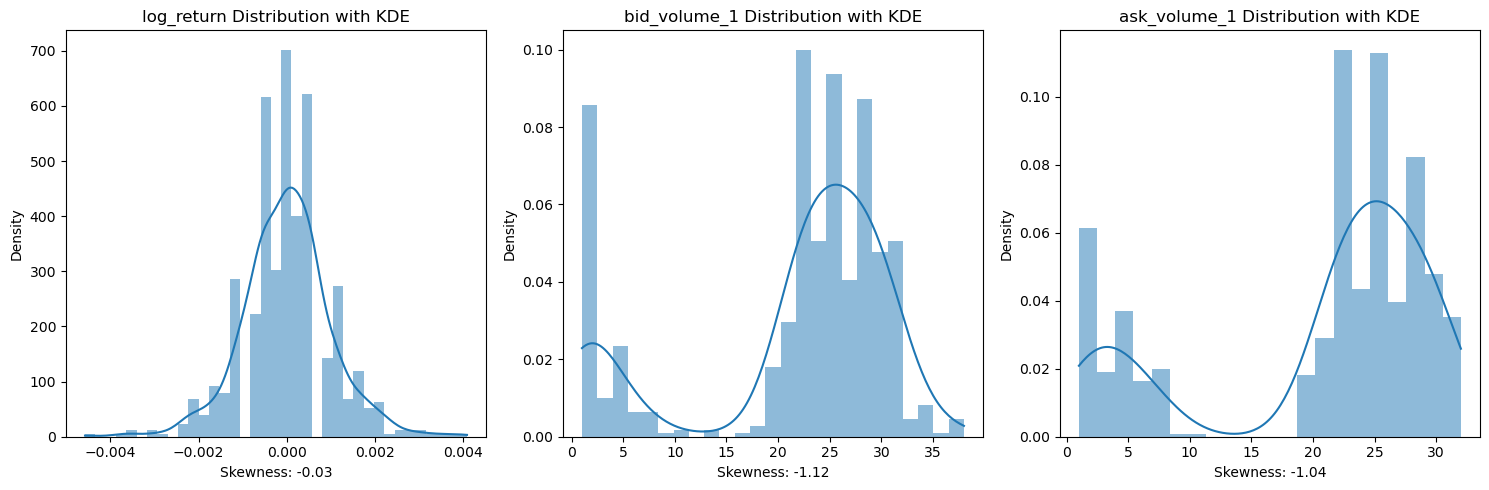

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming train_df has the relevant columns 'log_return', 'bid_volume_1', and 'ask_volume_1'
# Create a list of the columns to plot
columns_to_plot = ['log_return', 'bid_volume_1', 'ask_volume_1']

# Set up the plot with a single row of subplots
plt.figure(figsize=(15, 5))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 3, i)  # 1 row, 3 columns, for each feature
    sns.histplot(train_df[column], kde=True, stat='density', linewidth=0)
    plt.title(f'{column} Distribution with KDE')

    # Calculate skewness
    skewness = train_df[column].skew()
    plt.xlabel(f'Skewness: {skewness:.2f}')
    plt.ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()


lets plot the log returns of volume just to see what that looks like, would that be normal?

In [35]:
train_df['lagged_log_return_of_bid_volume_1'] = (np.log(train_df['bid_volume_1']) - np.log(train_df['bid_volume_1'].shift(1))).shift(1)
train_df['lagged_log_return_of_ask_volume_1'] = (np.log(train_df['ask_volume_1']) - np.log(train_df['ask_volume_1'].shift(1))).shift(1)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


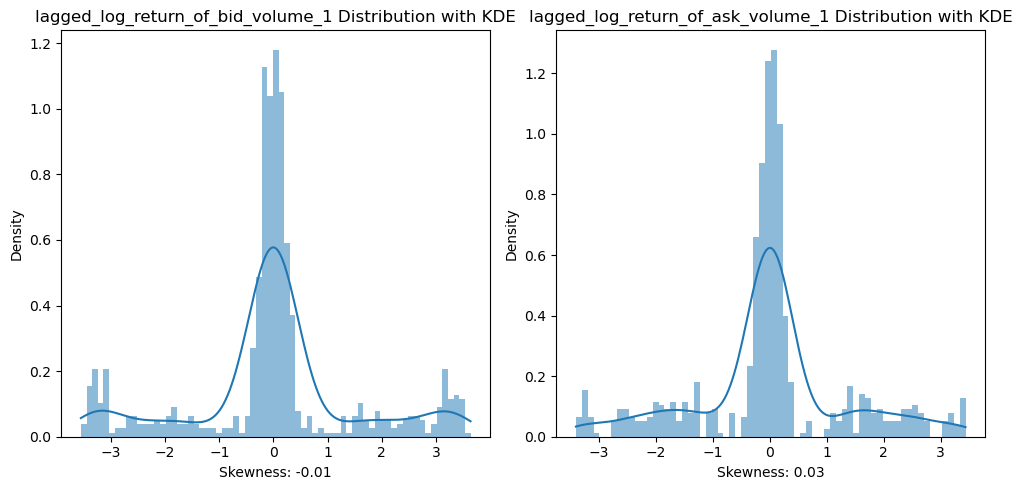

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming train_df has the relevant columns 'log_return', 'bid_volume_1', and 'ask_volume_1'
# Create a list of the columns to plot
columns_to_plot = ['lagged_log_return_of_bid_volume_1', 'lagged_log_return_of_ask_volume_1']

# Set up the plot with a single row of subplots
plt.figure(figsize=(15, 5))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 3, i)  # 1 row, 3 columns, for each feature
    sns.histplot(train_df[column], kde=True, stat='density', linewidth=0)
    plt.title(f'{column} Distribution with KDE')

    # Calculate skewness
    skewness = train_df[column].skew()
    plt.xlabel(f'Skewness: {skewness:.2f}')
    plt.ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()


Lets see how effective these are as features in the LR model

In [37]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define features and target
features = ['lag_1_return', 'lagged_log_return_of_bid_volume_1', 'lagged_log_return_of_ask_volume_1']
target = 'log_return'

# Drop NaNs in both train and test sets
train_data = train_df[features + [target]].dropna() 
test_data = test_df[features + [target]].dropna()

# Separate the features and target for training and testing
X_train = train_data[features].copy()  # Copy ensures original DataFrame is not modified
y_train = train_data[target]

X_test = test_data[features].copy()
y_test = test_data[target]

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame (optional, but useful for debugging)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Add constant term (intercept) after scaling
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Initialize and fit the Linear Regression model using statsmodels
model = sm.OLS(y_train, X_train_scaled)
results = model.fit()

# Print the summary of the regression model
print(results.summary())

# Make predictions on the test data
y_pred = results.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)

# Calculate R² on the test set
r2 = r2_score(y_test, y_pred)

# Display the results
print(f'Mean Squared Error (MSE) on the Test Set: {mse:.10f}')
print(f'R² Value on the Test Set: {r2:.6f}')


                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.106
Date:                Tue, 08 Apr 2025   Prob (F-statistic):            0.00665
Time:                        19:44:48   Log-Likelihood:                 4108.9
No. Observations:                 748   AIC:                            -8210.
Df Residuals:                     744   BIC:                            -8191.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

It seems like the lagged returns of volume isn't that useful. Remember that if it doesn't make too much sense we should be suspicious if results are much worse.

What about just log volume?

In [38]:
train_df['log_lag_1_ask_volume_1'] = np.log(train_df['lag_1_ask_volume_1'])
train_df['log_lag_1_bid_volume_1'] = np.log(train_df['lag_1_bid_volume_1'])
test_df['log_lag_1_ask_volume_1'] = np.log(test_df['lag_1_ask_volume_1'])
test_df['log_lag_1_bid_volume_1'] = np.log(test_df['lag_1_bid_volume_1'])

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


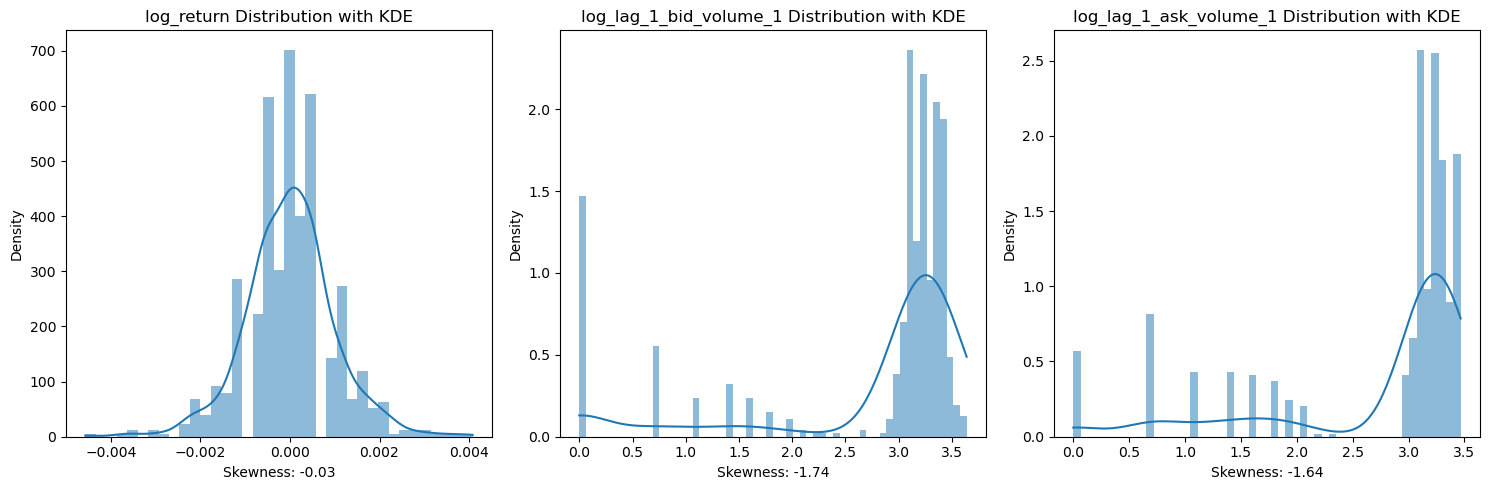

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming train_df has the relevant columns 'log_return', 'bid_volume_1', and 'ask_volume_1'
# Create a list of the columns to plot
columns_to_plot = ['log_return', 'log_lag_1_bid_volume_1', 'log_lag_1_ask_volume_1']

# Set up the plot with a single row of subplots
plt.figure(figsize=(15, 5))

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(1, 3, i)  # 1 row, 3 columns, for each feature
    sns.histplot(train_df[column], kde=True, stat='density', linewidth=0)
    plt.title(f'{column} Distribution with KDE')

    # Calculate skewness
    skewness = train_df[column].skew()
    plt.xlabel(f'Skewness: {skewness:.2f}')
    plt.ylabel('Density')

# Adjust layout
plt.tight_layout()
plt.show()


It seems like logging has increased the negative skew so not sure if this will be that helpful.

In [40]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define features and target
features = ['lag_1_return', 'log_lag_1_bid_volume_1', 'log_lag_1_ask_volume_1']
target = 'log_return'

# Drop NaNs in both train and test sets
train_data = train_df[features + [target]].dropna() 
test_data = test_df[features + [target]].dropna()

# Separate the features and target for training and testing
X_train = train_data[features].copy()  # Copy ensures original DataFrame is not modified
y_train = train_data[target]

X_test = test_data[features].copy()
y_test = test_data[target]

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame (optional, but useful for debugging)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Add constant term (intercept) after scaling
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Initialize and fit the Linear Regression model using statsmodels
model = sm.OLS(y_train, X_train_scaled)
results = model.fit()

# Print the summary of the regression model
print(results.summary())

# Make predictions on the test data
y_pred = results.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)

# Calculate R² on the test set
r2 = r2_score(y_test, y_pred)

# Display the results
print(f'Mean Squared Error (MSE) on the Test Set: {mse:.10f}')
print(f'R² Value on the Test Set: {r2:.6f}')


                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     10.01
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           1.80e-06
Time:                        19:44:49   Log-Likelihood:                 4117.6
No. Observations:                 748   AIC:                            -8227.
Df Residuals:                     744   BIC:                            -8209.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4.00

Results seem to agree with this, LR becomes worse as the data has become skewed and less normal.

Now lets go back to our best LR model and check if the linear regression assumptions are true.

In [43]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Define features and target
features = ['ask_volume_PCA', 'bid_volume_PCA', 'lag_1_return', 'lag_1_askvol_return_interaction', 'lag_1_bidvol_return_interaction']
target = 'log_return'

# Drop NaNs in both train and test sets
train_data = train_df[features + [target]].dropna() 
test_data = test_df[features + [target]].dropna()

# Separate the features and target for training and testing
X_train = train_data[features].copy()  # Copy ensures original DataFrame is not modified
y_train = train_data[target]

X_test = test_data[features].copy()
y_test = test_data[target]

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame (optional, but useful for debugging)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

# Add constant term (intercept) after scaling
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Initialize and fit the Linear Regression model using statsmodels
model = sm.OLS(y_train, X_train_scaled)
results = model.fit()

# Print the summary of the regression model
print(results.summary())

# Make predictions on the test data
y_pred = results.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)

# Calculate R² on the test set
r2 = r2_score(y_test, y_pred)

# Display the results
print(f'Mean Squared Error (MSE) on the Test Set: {mse:.10f}')
print(f'R² Value on the Test Set: {r2:.6f}')


                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     7.279
Date:                Tue, 08 Apr 2025   Prob (F-statistic):           1.14e-06
Time:                        19:46:25   Log-Likelihood:                 4120.7
No. Observations:                 748   AIC:                            -8229.
Df Residuals:                     742   BIC:                            -8202.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


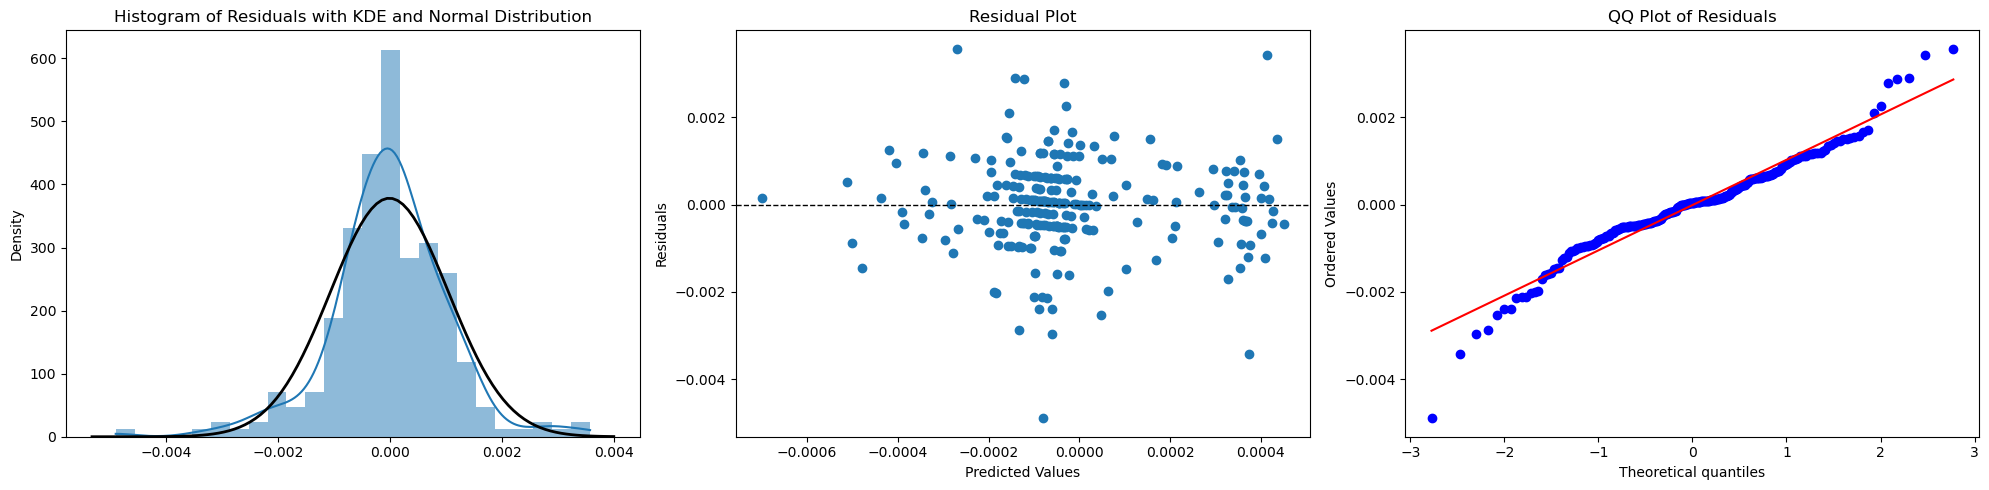

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

# Calculate residuals (errors from the linear model)
residuals = y_test - y_pred

# Set up the plots in a single row
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1. Histogram of residuals with KDE and normal distribution fitted
sns.histplot(residuals, kde=True, stat='density', linewidth=0, ax=axes[0])
xmin, xmax = axes[0].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
axes[0].plot(x, p, 'k', linewidth=2)
axes[0].set_title('Histogram of Residuals with KDE and Normal Distribution')

# 2. Residual Plot
axes[1].scatter(y_pred, residuals)
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

# 3. QQ Plot
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('QQ Plot of Residuals')

# Adjust layout to fit in one row
plt.tight_layout()
plt.show()


It seems like the residuals are mostly normally distributed, have roughly equal variance and follow a normal distribution from a qqplot without significant skew, which suggests our LR is likely to be valid.